In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np
import pandas as pd
import sys
from os import system
from lifelines import KaplanMeierFitter
from lifelines import CoxPHFitter
from lifelines import statistics
from scipy.stats import variation
from IPython.display import clear_output
from scipy.stats import pearsonr
from scipy.stats import spearmanr
import phik 
import seaborn as sns
from phik import resources, report
from phik.report import plot_correlation_matrix
from itertools import combinations
import random
from tabulate import tabulate
from IPython.display import display, HTML
import graphviz
import networkx as nx
import itertools

In [2]:
import sys

class add_path():
    def __init__(self, path):
        self.path = path

    def __enter__(self):
        sys.path.insert(0, self.path)

    def __exit__(self, exc_type, exc_value, traceback):
        try:
            sys.path.remove(self.path)
        except ValueError:
            pass
with add_path('/home/hshadman/.local/lib/python3.7/site-packages'):
    matplotlib = __import__('matplotlib')

In [3]:
matplotlib.__version__

'3.5.3'

In [4]:

from graphviz import Digraph
gra = Digraph()
gra.node('a', 'Machine Learning Errors')

gra.node('b', 'RMSE')

gra.node('c', 'MAE')
gra.edges(['ab', 'ac'])

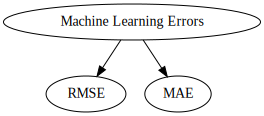

In [5]:
gra

In [6]:
print(gra.source)

digraph {
	a [label="Machine Learning Errors"]
	b [label=RMSE]
	c [label=MAE]
	a -> b
	a -> c
}


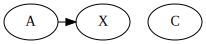

In [7]:
gra = Digraph()
with gra.subgraph() as i:

    i.attr(rank='same')

    i.node('A')

    i.node('X')

gra.node('C')
gra.edges(['AX'])
gra


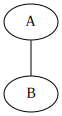

In [8]:
import graphviz
g = graphviz.Graph()
g.node('A')
g.node('B')
g.edge('A','B')
g

# load functions 
# load the datasets, set cutoff values, correlation method (these are done individually so the system saves them globallly)

In [9]:
gtex_toil_dataset = '../gtex_RSEM_gene_tpm.gz'
correlation_method ='pearson'
correlation_cutoff = 0.6
tcga_hiseq_dataset = '/home/hshadman/integrins_expression/saghar_TCGA_Breast/TCGA_BRCA_HiSeqV2' 
tcga_toil_pancanc = "../gtex_and_tcga/tcga_RSEM_gene_tpm.gz"
tcga_hiseq_corresponding_sample_info = '/home/hshadman/integrins_expression/saghar_TCGA_Breast/TCGA.BRCA.sampleMap_BRCA_clinicalMatrix'
tcga_toil_sampinfo = "../gtex_and_tcga/TCGA_phenotype_denseDataOnlyDownload.tsv.gz"
tcga_toil_clincinfo = "../gtex_and_tcga/Survival_SupplementalTable_S1_20171025_xena_sp"
opposing_corr_cutoff = 0.1


In [10]:
#functions for data processing
def gtex_data_processing(gtex_toil_dataset):
    unwanted_integrins = ['ITGB3BP','ITGB1BP1','ITGB5-AS1','ITGA9-AS1','ITGB1P1','ITGB2-AS1', 'ITGB1BP2','ITGB1BP3']
    gtex_breast_data_all = pd.read_csv(gtex_toil_dataset,sep='\t')
    gtex_breast_data_all=gtex_breast_data_all.set_index('sample').copy()

    #next map gene names
    gene_map = pd.read_csv("../gtex_and_tcga/probeMap_gencode.v23.annotation.gene.probemap",sep='\t')
    #make another column with the isoform label stripped off
    gene_map['id_neutral']=[geneid.split('.')[0] for geneid in gene_map.id.values]
    protein_coding_genes=pd.read_csv("protein_coding_genes_mart_export.txt",sep='\t')
    #remove rows with nan values
    protein_coding_genes = protein_coding_genes.dropna(axis=0,how='any')
    #subset probemap with protein coding genes
    gene_map = gene_map[gene_map.id_neutral.isin([geneID.split('.')[0] for geneID in protein_coding_genes['Gene stable ID'].values])]

    gene_map = gene_map[~gene_map.index.duplicated(keep='first')]
    gene_id = gene_map.id.values.tolist()
    gene_name = gene_map["gene"].values.tolist()
    print('before dropping duplicates',len(gene_id),len(gene_name))
    gene_duplicate = gene_map[gene_map.duplicated(subset="gene")]
    gene_duplicate = gene_duplicate.sort_values('gene', axis='index')
    gene_map.drop_duplicates(subset="gene", inplace=True, keep='first')
    gene_id = gene_map.index.values.tolist()
    gene_name = gene_map["gene"].values.tolist()
    print('after dropping duplicates',len(gene_id),len(gene_name))
    # Drop all those duplicated genes from gene expression DataFrame
    duplicate_drop = gene_duplicate.id.values  #these are the gene ids that are duplicated
    gtex_breast_data_all.drop(duplicate_drop, axis='index',inplace=True)
    gene_map_dict = dict(zip(gene_map.id, gene_map.gene))
    gtex_breast_data_all=gtex_breast_data_all.loc[gtex_breast_data_all.index.isin(list(gene_map.id.values))]
    gtex_breast_data_all=pd.concat([gtex_breast_data_all,gene_map.set_index('id')],axis=1).set_index('gene').iloc[:,0:gtex_breast_data_all.shape[1]]
    gtex_breast_data_all=gtex_breast_data_all.T.astype('float').copy()
    df_int = gtex_breast_data_all.copy()
    #drop unwanted integrins    
    df_int=df_int.drop([undesired_integrin for undesired_integrin in df_int.columns if undesired_integrin in unwanted_integrins],axis=1)
    #drop duplicate gene names (if any) 
    df_int=df_int.loc[:,~df_int.columns.duplicated()]    
    
    gtex_toil_phenotype = pd.read_csv('../GTEX_phenotype.gz',sep='\t')
    #subset for breast
    gtex_toil_phenotype = gtex_toil_phenotype[gtex_toil_phenotype['body_site_detail (SMTSD)']=='Breast - Mammary Tissue']
    #subset for female gender
    gtex_toil_phenotype = gtex_toil_phenotype[gtex_toil_phenotype._gender=='female']

    #select breast female gtex gene expression data
    df_int=df_int.loc[df_int.index.isin(gtex_toil_phenotype.Sample.values)].copy()
    
    return df_int

def tcga_data_processing(tcga_toil_pancanc,tcga_toil_sampinfo):
    global tcga_brca_df, tcga_brca_sample_info
    unwanted_integrins = ['ITGB3BP','ITGB1BP1','ITGB5-AS1','ITGA9-AS1','ITGB1P1','ITGB2-AS1', 'ITGB1BP2','ITGB1BP3']    
    #First obtaining TCGA BRCA df from TCGA pan cancer
    #sample info first file 
    pan_tcga_phenotype_sampinfo = pd.read_csv(tcga_toil_sampinfo,
                                       sep='\t',encoding='latin-1')
    pan_tcga_phenotype_sampinfo = pan_tcga_phenotype_sampinfo.set_index('sample')
    #subset breast invasive carcinoma
    chosen_canc='breast invasive carcinoma'
    pan_tcga_phenotype_sampinfo = pan_tcga_phenotype_sampinfo[pan_tcga_phenotype_sampinfo._primary_disease==chosen_canc]


    #sample info second file
    pan_tcga_phenotype_clinfo = pd.read_csv("../gtex_and_tcga/Survival_SupplementalTable_S1_20171025_xena_sp",
                                       sep='\t',encoding='latin-1')
    pan_tcga_phenotype_clinfo = pan_tcga_phenotype_clinfo.set_index('sample')
    #subset for BRCA
    pan_tcga_phenotype_clinfo = pan_tcga_phenotype_clinfo[pan_tcga_phenotype_clinfo['cancer type abbreviation']=='BRCA']

    #set common indices for both files
    common_indices = pan_tcga_phenotype_sampinfo.index.intersection(pan_tcga_phenotype_clinfo.index)
    pan_tcga_phenotype_sampinfo = pan_tcga_phenotype_sampinfo.loc[common_indices]
    pan_tcga_phenotype_clinfo = pan_tcga_phenotype_clinfo.loc[common_indices]
    tcga_brca_sample_info = pd.concat([pan_tcga_phenotype_sampinfo,pan_tcga_phenotype_clinfo],axis=1)

    #subset females only
    tcga_brca_sample_info = tcga_brca_sample_info[tcga_brca_sample_info.gender =='FEMALE']


    del pan_tcga_phenotype_sampinfo,pan_tcga_phenotype_clinfo

    #retrieve TCGA pancan TOIL data - all cancers
    pan_tcga = pd.read_csv(tcga_toil_pancanc,sep='\t')

    #subset the relevant TCGA BRCA data from pan cancer 
    chosen_samples = list(tcga_brca_sample_info.index.values)
    tcga_brca_df = pan_tcga[pan_tcga.columns[pan_tcga.columns.isin(['sample']+chosen_samples)]]
    tcga_brca_df = tcga_brca_df.set_index('sample')
    del pan_tcga, chosen_samples
    #next map gene names
    gene_map = pd.read_csv("../gtex_and_tcga/probeMap_gencode.v23.annotation.gene.probemap",sep='\t')
    #make another column with the isoform label stripped off
    gene_map['id_neutral']=[geneid.split('.')[0] for geneid in gene_map.id.values]
    protein_coding_genes=pd.read_csv("protein_coding_genes_mart_export.txt",sep='\t')
    #remove rows with nan values
    protein_coding_genes = protein_coding_genes.dropna(axis=0,how='any')
    #subset probemap with protein coding genes
    gene_map = gene_map[gene_map.id_neutral.isin([geneID.split('.')[0] for geneID in protein_coding_genes['Gene stable ID'].values])]
    gene_map = gene_map[~gene_map.index.duplicated(keep='first')]
    gene_id = gene_map.id.values.tolist()
    gene_name = gene_map["gene"].values.tolist()
    print('before dropping duplicates',len(gene_id),len(gene_name))
    gene_duplicate = gene_map[gene_map.duplicated(subset="gene")]
    gene_duplicate = gene_duplicate.sort_values('gene', axis='index')
    gene_map.drop_duplicates(subset="gene", inplace=True, keep='first')
    gene_id = gene_map.index.values.tolist()
    gene_name = gene_map["gene"].values.tolist()
    print('after dropping duplicates',len(gene_id),len(gene_name))
    # Drop all those duplicated genes from gene expression DataFrame
    duplicate_drop = gene_duplicate.id.values  #these are the gene ids that are duplicated
    tcga_brca_df.drop(duplicate_drop, axis='index',inplace=True)
    gene_map_dict = dict(zip(gene_map.id, gene_map.gene))
    tcga_brca_df=tcga_brca_df.loc[tcga_brca_df.index.isin(list(gene_map.id.values))]
    tcga_brca_df=pd.concat([tcga_brca_df,gene_map.set_index('id')],axis=1).set_index('gene').iloc[:,0:tcga_brca_df.shape[1]]
    #now first step down, we have tcga_brca_df, and tcga_brca_sample_info
    #subsequent steps derive from these two dataframe files
    
    
    #drop unwanted integrins    
    tcga_brca_df=tcga_brca_df.loc[~tcga_brca_df.index.isin(unwanted_integrins)]
    #drop duplicate gene names (if any)
    tcga_brca_df=tcga_brca_df.loc[~tcga_brca_df.index.duplicated()]    

    #drop metastatic from main sample type data frame
    #tcga_brca_sample_info = tcga_brca_sample_info[~(tcga_brca_sample_info.sample_type=='Metastatic')]
 
    #separate normal and primtum (remember primary tumor contains multiple stages)
    tcga_brca_normal_patients = tcga_brca_sample_info[tcga_brca_sample_info.sample_type=='Solid Tissue Normal']
    tcga_brca_primtum_patients = tcga_brca_sample_info[tcga_brca_sample_info.sample_type=='Primary Tumor']

    #drop index of samples not in tcga_brca_df
    tcga_brca_normal_patients = tcga_brca_normal_patients.drop(non_match for non_match in tcga_brca_normal_patients.index.values if non_match not in tcga_brca_df.columns)
    tcga_brca_primtum_patients = tcga_brca_primtum_patients.drop(non_match for non_match in tcga_brca_primtum_patients.index.values if non_match not in tcga_brca_df.columns) 


    #make sure both normal and tumor patients match, and drop patients not in tcga_brca_df
    matched_patient_index_list=[]
    for patient in tcga_brca_primtum_patients._PATIENT.values:
        if patient in tcga_brca_normal_patients._PATIENT.values and patient in ['-'.join(patient_id.split('-')[0:3]) for patient_id in tcga_brca_df.columns]:
            matched_patient_index_list.append(tcga_brca_sample_info[tcga_brca_sample_info._PATIENT==patient].index.values)
    matched_patient_list=tcga_brca_sample_info.loc[[x for l in matched_patient_index_list for x in l]].copy()


    # matched_patient_id_list=pd.Index(tcga_brca_normal_patients['_PATIENT']).intersection(pd.Index(tcga_brca_primtum_patients['_PATIENT']))
    # matched_patient_index_list=tcga_brca_sample_info[tcga_brca_sample_info._PATIENT.isin(matched_patient_id_list)].index.values
    # matched_patient_list = tcga_brca_sample_info.loc[[l for l in matched_patient_index_list]].copy()
    # #ensure samples are present in tcga_brca_df
    # matched_patient_list=matched_patient_list.loc[matched_patient_list.index.intersection(pd.Index(tcga_brca_df.columns))]

    #separate normal and primary tumor
    normal_matched_patient_list=matched_patient_list[matched_patient_list.sample_type=='Solid Tissue Normal']
    primtum_matched_patient_list = matched_patient_list[matched_patient_list.sample_type=='Primary Tumor']

    #matched normal and primary tumor samples
    tcga_brca_df_normal_matched=tcga_brca_df[tcga_brca_df.columns[tcga_brca_df.columns.isin(normal_matched_patient_list.index.values)]]
    tcga_brca_df_primtum_matched=tcga_brca_df[tcga_brca_df.columns[tcga_brca_df.columns.isin(primtum_matched_patient_list.index.values)]]

    #test to see if normal and primary tumor patient IDs are a match
    for i in [patient_id.split('-')[2] for patient_id in tcga_brca_df_normal_matched.columns]:
        if i not in [patient_id.split('-')[2] for patient_id in tcga_brca_df_primtum_matched.columns]:
            print('trouble')

    #TCGA brca normal ALL
    tcga_brca_df_normal_all = tcga_brca_df.T.loc[tcga_brca_normal_patients.index.values].copy()
    # dataframe with all TCGA primary tumor samples (not necessarily matched)
    tcga_brca_df_primtum_all= tcga_brca_df.T.loc[tcga_brca_primtum_patients.index.values].copy()
    
    return {'tcga_brca_df_normal_matched':tcga_brca_df_normal_matched,
           'tcga_brca_df_primtum_matched':tcga_brca_df_primtum_matched,
           'tcga_brca_df_normal_all':tcga_brca_df_normal_all,
           'tcga_brca_df_primtum_all':tcga_brca_df_primtum_all}

def correlation_selected_gene(provided_dataset,interest_gene,correlation_method):
    dataset_corr = provided_dataset.corrwith(provided_dataset[interest_gene],
                                             method=correlation_method).drop(interest_gene)
    dataset_corr = dataset_corr.dropna(axis=0,how='any')
    idx = dataset_corr.index.drop_duplicates(keep=False)
    dataset_corr = dataset_corr.loc[idx]
    return dataset_corr
def pairwise_pearson_correlation(provided_dataset):
    #columns have to be variables and rows have to be observations
    pairwise_corr=pd.DataFrame(np.corrcoef(provided_dataset,rowvar=False),
                               columns=provided_dataset.columns,index=provided_dataset.columns)



In [11]:
def early_stage_tcga_data_processing(tcga_toil_pancanc,tcga_toil_sampinfo):
    unwanted_integrins = ['ITGB3BP','ITGB1BP1','ITGB5-AS1','ITGA9-AS1','ITGB1P1','ITGB2-AS1', 'ITGB1BP2','ITGB1BP3']    
    #First obtaining TCGA BRCA df from TCGA pan cancer
    #sample info first file 
    pan_tcga_phenotype_sampinfo = pd.read_csv(tcga_toil_sampinfo,
                                       sep='\t',encoding='latin-1')
    pan_tcga_phenotype_sampinfo = pan_tcga_phenotype_sampinfo.set_index('sample')
    #subset breast invasive carcinoma
    chosen_canc='breast invasive carcinoma'
    pan_tcga_phenotype_sampinfo = pan_tcga_phenotype_sampinfo[pan_tcga_phenotype_sampinfo._primary_disease==chosen_canc]


    #sample info second file
    pan_tcga_phenotype_clinfo = pd.read_csv("../gtex_and_tcga/Survival_SupplementalTable_S1_20171025_xena_sp",
                                       sep='\t',encoding='latin-1')
    pan_tcga_phenotype_clinfo = pan_tcga_phenotype_clinfo.set_index('sample')
    #subset for BRCA
    pan_tcga_phenotype_clinfo = pan_tcga_phenotype_clinfo[pan_tcga_phenotype_clinfo['cancer type abbreviation']=='BRCA']

    #set common indices for both files
    common_indices = pan_tcga_phenotype_sampinfo.index.intersection(pan_tcga_phenotype_clinfo.index)
    pan_tcga_phenotype_sampinfo = pan_tcga_phenotype_sampinfo.loc[common_indices]
    pan_tcga_phenotype_clinfo = pan_tcga_phenotype_clinfo.loc[common_indices]
    tcga_brca_sample_info = pd.concat([pan_tcga_phenotype_sampinfo,pan_tcga_phenotype_clinfo],axis=1)

    #subset females only
    tcga_brca_sample_info = tcga_brca_sample_info[tcga_brca_sample_info.gender =='FEMALE']


    del pan_tcga_phenotype_sampinfo,pan_tcga_phenotype_clinfo

    #retrieve TCGA pancan TOIL data - all cancers
    pan_tcga = pd.read_csv(tcga_toil_pancanc,sep='\t')

    #subset the relevant TCGA BRCA data from pan cancer 
    chosen_samples = list(tcga_brca_sample_info.index.values)
    tcga_brca_df = pan_tcga[pan_tcga.columns[pan_tcga.columns.isin(['sample']+chosen_samples)]]
    tcga_brca_df = tcga_brca_df.set_index('sample')
    del pan_tcga, chosen_samples
    #next map gene names
    gene_map = pd.read_csv("../gtex_and_tcga/probeMap_gencode.v23.annotation.gene.probemap",sep='\t')
    #make another column with the isoform label stripped off
    gene_map['id_neutral']=[geneid.split('.')[0] for geneid in gene_map.id.values]
    protein_coding_genes=pd.read_csv("protein_coding_genes_mart_export.txt",sep='\t')
    #remove rows with nan values
    protein_coding_genes = protein_coding_genes.dropna(axis=0,how='any')
    #subset probemap with protein coding genes
    gene_map = gene_map[gene_map.id_neutral.isin([geneID.split('.')[0] for geneID in protein_coding_genes['Gene stable ID'].values])]
    gene_map = gene_map[~gene_map.index.duplicated(keep='first')]
    gene_id = gene_map.id.values.tolist()
    gene_name = gene_map["gene"].values.tolist()
    print('before dropping duplicates',len(gene_id),len(gene_name))
    gene_duplicate = gene_map[gene_map.duplicated(subset="gene")]
    gene_duplicate = gene_duplicate.sort_values('gene', axis='index')
    gene_map.drop_duplicates(subset="gene", inplace=True, keep='first')
    gene_id = gene_map.index.values.tolist()
    gene_name = gene_map["gene"].values.tolist()
    print('after dropping duplicates',len(gene_id),len(gene_name))
    # Drop all those duplicated genes from gene expression DataFrame
    duplicate_drop = gene_duplicate.id.values  #these are the gene ids that are duplicated
    tcga_brca_df.drop(duplicate_drop, axis='index',inplace=True)
    gene_map_dict = dict(zip(gene_map.id, gene_map.gene))
    tcga_brca_df=tcga_brca_df.loc[tcga_brca_df.index.isin(list(gene_map.id.values))]
    tcga_brca_df=pd.concat([tcga_brca_df,gene_map.set_index('id')],axis=1).set_index('gene').iloc[:,0:tcga_brca_df.shape[1]]
    #now first step down, we have tcga_brca_df, and tcga_brca_sample_info
    #subsequent steps derive from these two dataframe files
    
    
    #drop unwanted integrins    
    tcga_brca_df=tcga_brca_df.loc[~tcga_brca_df.index.isin(unwanted_integrins)]
    #drop duplicate gene names (if any)
    tcga_brca_df=tcga_brca_df.loc[~tcga_brca_df.index.duplicated()]    

    #drop metastatic from main sample type data frame
    tcga_brca_sample_info = tcga_brca_sample_info[~(tcga_brca_sample_info.sample_type=='Metastatic')]
    #drop normal samples
    tcga_brca_sample_info = tcga_brca_sample_info[~(tcga_brca_sample_info.sample_type=='Solid Tissue Normal')]    

    #make sure only primary tumor sample types
    tcga_brca_primtum_patients = tcga_brca_sample_info[tcga_brca_sample_info.sample_type=='Primary Tumor']
    
    #stage I and II only
    #early_stages=['Stage IIB', 'Stage IA','Stage IIA','Stage I','Stage IB','Stage II']    
    
    #stage I only
    early_stages=[ 'Stage IA','Stage I','Stage IB']    
    
    tcga_brca_primtum_patients=tcga_brca_primtum_patients[tcga_brca_primtum_patients.ajcc_pathologic_tumor_stage.isin(early_stages)]
    
    #drop index of samples not in tcga_brca_df

    tcga_brca_primtum_patients =tcga_brca_primtum_patients.drop(non_match for non_match in tcga_brca_primtum_patients.index.values if non_match not in tcga_brca_df.columns) 



    # dataframe with all TCGA primary early stage tumor samples (not necessarily matched)
    tcga_brca_df_primtum_early_stage= tcga_brca_df.T.loc[tcga_brca_primtum_patients.index.values].copy()
    
    return {'tcga_brca_df_primtum_early_stage':tcga_brca_df_primtum_early_stage}

def late_stage_tcga_data_processing(tcga_toil_pancanc,tcga_toil_sampinfo):
    unwanted_integrins = ['ITGB3BP','ITGB1BP1','ITGB5-AS1','ITGA9-AS1','ITGB1P1','ITGB2-AS1', 'ITGB1BP2','ITGB1BP3']    
    #First obtaining TCGA BRCA df from TCGA pan cancer
    #sample info first file 
    pan_tcga_phenotype_sampinfo = pd.read_csv(tcga_toil_sampinfo,
                                       sep='\t',encoding='latin-1')
    pan_tcga_phenotype_sampinfo = pan_tcga_phenotype_sampinfo.set_index('sample')
    #subset breast invasive carcinoma
    chosen_canc='breast invasive carcinoma'
    pan_tcga_phenotype_sampinfo = pan_tcga_phenotype_sampinfo[pan_tcga_phenotype_sampinfo._primary_disease==chosen_canc]


    #sample info second file
    pan_tcga_phenotype_clinfo = pd.read_csv("../gtex_and_tcga/Survival_SupplementalTable_S1_20171025_xena_sp",
                                       sep='\t',encoding='latin-1')
    pan_tcga_phenotype_clinfo = pan_tcga_phenotype_clinfo.set_index('sample')
    #subset for BRCA
    pan_tcga_phenotype_clinfo = pan_tcga_phenotype_clinfo[pan_tcga_phenotype_clinfo['cancer type abbreviation']=='BRCA']

    #set common indices for both files
    common_indices = pan_tcga_phenotype_sampinfo.index.intersection(pan_tcga_phenotype_clinfo.index)
    pan_tcga_phenotype_sampinfo = pan_tcga_phenotype_sampinfo.loc[common_indices]
    pan_tcga_phenotype_clinfo = pan_tcga_phenotype_clinfo.loc[common_indices]
    tcga_brca_sample_info = pd.concat([pan_tcga_phenotype_sampinfo,pan_tcga_phenotype_clinfo],axis=1)

    #subset females only
    tcga_brca_sample_info = tcga_brca_sample_info[tcga_brca_sample_info.gender =='FEMALE']


    del pan_tcga_phenotype_sampinfo,pan_tcga_phenotype_clinfo

    #retrieve TCGA pancan TOIL data - all cancers
    pan_tcga = pd.read_csv(tcga_toil_pancanc,sep='\t')

    #subset the relevant TCGA BRCA data from pan cancer 
    chosen_samples = list(tcga_brca_sample_info.index.values)
    tcga_brca_df = pan_tcga[pan_tcga.columns[pan_tcga.columns.isin(['sample']+chosen_samples)]]
    tcga_brca_df = tcga_brca_df.set_index('sample')
    del pan_tcga, chosen_samples
    #next map gene names
    gene_map = pd.read_csv("../gtex_and_tcga/probeMap_gencode.v23.annotation.gene.probemap",sep='\t')
    #make another column with the isoform label stripped off
    gene_map['id_neutral']=[geneid.split('.')[0] for geneid in gene_map.id.values]
    protein_coding_genes=pd.read_csv("protein_coding_genes_mart_export.txt",sep='\t')
    #remove rows with nan values
    protein_coding_genes = protein_coding_genes.dropna(axis=0,how='any')
    #subset probemap with protein coding genes
    gene_map = gene_map[gene_map.id_neutral.isin([geneID.split('.')[0] for geneID in protein_coding_genes['Gene stable ID'].values])]

    gene_map = gene_map[~gene_map.index.duplicated(keep='first')]
    gene_id = gene_map.id.values.tolist()
    gene_name = gene_map["gene"].values.tolist()
    print('before dropping duplicates',len(gene_id),len(gene_name))
    gene_duplicate = gene_map[gene_map.duplicated(subset="gene")]
    gene_duplicate = gene_duplicate.sort_values('gene', axis='index')
    gene_map.drop_duplicates(subset="gene", inplace=True, keep='first')
    gene_id = gene_map.index.values.tolist()
    gene_name = gene_map["gene"].values.tolist()
    print('after dropping duplicates',len(gene_id),len(gene_name))
    # Drop all those duplicated genes from gene expression DataFrame
    duplicate_drop = gene_duplicate.id.values  #these are the gene ids that are duplicated
    tcga_brca_df.drop(duplicate_drop, axis='index',inplace=True)
    gene_map_dict = dict(zip(gene_map.id, gene_map.gene))
    tcga_brca_df=tcga_brca_df.loc[tcga_brca_df.index.isin(list(gene_map.id.values))]    
    tcga_brca_df=pd.concat([tcga_brca_df,gene_map.set_index('id')],axis=1).set_index('gene').iloc[:,0:tcga_brca_df.shape[1]]
    #now first step down, we have tcga_brca_df, and tcga_brca_sample_info
    #subsequent steps derive from these two dataframe files
    
    
    #drop unwanted integrins    
    tcga_brca_df=tcga_brca_df.loc[~tcga_brca_df.index.isin(unwanted_integrins)]
    #drop duplicate gene names (if any)
    tcga_brca_df=tcga_brca_df.loc[~tcga_brca_df.index.duplicated()]    

    #drop normal samples
    tcga_brca_sample_info = tcga_brca_sample_info[~(tcga_brca_sample_info.sample_type=='Solid Tissue Normal')]    
    #make sure only primary tumor sample types
    tcga_brca_primtum_patients = tcga_brca_sample_info

    late_stages=['Stage IIIA', 'Stage IV','Stage IIIC','Stage IIIB','Stage III']    
    
    tcga_brca_primtum_patients=tcga_brca_primtum_patients[tcga_brca_primtum_patients.ajcc_pathologic_tumor_stage.isin(late_stages)]
    
    #drop index of samples not in tcga_brca_df

    tcga_brca_primtum_patients =tcga_brca_primtum_patients.drop(non_match for non_match in tcga_brca_primtum_patients.index.values if non_match not in tcga_brca_df.columns) 



    # dataframe with all TCGA primary late stage tumor samples (not necessarily matched)
    tcga_brca_df_primtum_late_stage= tcga_brca_df.T.loc[tcga_brca_primtum_patients.index.values].copy()
    
    return {'tcga_brca_df_primtum_late_stage':tcga_brca_df_primtum_late_stage}


In [12]:
#files loading
df_int=gtex_data_processing(gtex_toil_dataset)
tcga_data=tcga_data_processing(tcga_toil_pancanc,tcga_toil_sampinfo)
tcga_brca_df_normal_all=tcga_data['tcga_brca_df_normal_all']
tcga_brca_df_primtum_all=tcga_data['tcga_brca_df_primtum_all']
tcga_brca_df_normal_matched=tcga_data['tcga_brca_df_normal_matched']
tcga_brca_df_primtum_matched=tcga_data['tcga_brca_df_primtum_matched']
tcga_brca_df_primtum_early_stage=early_stage_tcga_data_processing(tcga_toil_pancanc,tcga_toil_sampinfo)['tcga_brca_df_primtum_early_stage']
tcga_brca_df_primtum_late_stage=late_stage_tcga_data_processing(tcga_toil_pancanc,tcga_toil_sampinfo)['tcga_brca_df_primtum_late_stage']


before dropping duplicates 19165 19165
after dropping duplicates 19158 19158
before dropping duplicates 19165 19165
after dropping duplicates 19158 19158
before dropping duplicates 19165 19165
after dropping duplicates 19158 19158
before dropping duplicates 19165 19165
after dropping duplicates 19158 19158


# COX regression using TOIL data

In [13]:
#this is the list of integrins
itg_list = tcga_brca_df_primtum_all.columns[tcga_brca_df_primtum_all.columns.str.contains('ITG')]
itg_list

Index(['ITGA10', 'ITGAD', 'ITGAM', 'ITGA3', 'ITGBL1', 'ITGAE', 'ITGA2',
       'ITGB3', 'ITGA7', 'ITGB8', 'ITGAX', 'ITGAV', 'ITGB6', 'ITGB7', 'ITGA5',
       'ITGB4', 'ITGB2', 'ITGA6', 'ITGA2B', 'ITGB1', 'ITGAL', 'ITGA9', 'ITGB5',
       'ITGA8', 'ITGA4', 'ITGA1', 'ITGA11'],
      dtype='object', name='gene')

<AxesSubplot:xlabel='gene', ylabel='value'>

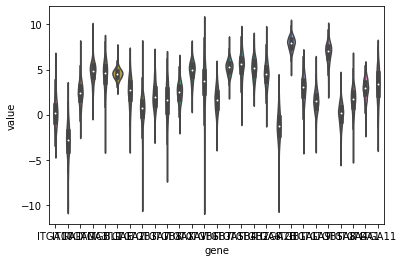

In [120]:
melted_tcga_brca_df_primtum_all=pd.melt(tcga_brca_df_primtum_all[itg_list]).copy()

sns.violinplot(melted_tcga_brca_df_primtum_all,x='gene',y='value')

In [119]:
#TCGA BRCA female samples ONLY, sample type primary tumor.
#The columns are showing genes
#The rows are showing sample identifiers

tcga_brca_df_primtum_all

gene,RAB4B,TIGAR,RNF44,DNAH3,RPL23A,ARL8B,CALB2,DACH1,FMO2,ZNF708,...,ARHGAP21,DDX47,POMZP3,EIF5B,KIF16B,CYP4F2,TENM1,BATF3,PPP6R1,OR8D4
TCGA-A2-A25D-01,4.606500,2.087800,4.013600,-6.506400,11.309500,5.442300,0.949300,1.239400,1.125000,0.465700,...,2.342300,4.993300,4.004600,5.660500,3.087600,-9.965800,-5.573500,1.475600,5.005400,-9.965800
TCGA-AC-A23H-01,4.863000,3.370300,3.854100,-3.307600,10.315300,6.788600,-0.013000,4.588000,-2.727400,2.828000,...,3.997400,4.939700,3.529900,6.115800,5.645300,-6.506400,-5.011600,-0.394000,4.991500,-9.965800
TCGA-AC-A3W6-01,5.801700,1.832300,4.593400,-3.625900,10.239600,5.074300,2.046500,1.766000,-0.072500,1.356700,...,3.876900,4.965400,4.137600,4.539800,3.807500,-6.506400,-2.932400,2.858200,5.178000,-9.965800
TCGA-B6-A0IC-01,5.967000,2.251300,4.930300,-6.506400,10.273000,6.250000,-2.465900,4.910800,-4.608200,3.032300,...,4.845000,5.673300,4.525500,5.682600,4.157900,-0.913200,-6.506400,-1.639400,5.275000,-9.965800
TCGA-BH-A1F8-01,5.061800,3.931800,4.399900,-1.639400,10.116400,6.537800,1.395600,5.608200,0.749300,2.077600,...,4.454200,5.971100,4.611800,6.418700,5.051900,-3.307600,-5.011600,-1.181100,4.858000,-9.965800
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-A7-A26E-01,3.572211,1.981021,3.347313,-5.573492,8.763819,5.730238,-0.425985,3.692402,1.940197,2.512048,...,4.101883,4.829582,1.661934,4.582419,3.317222,-5.573422,-4.864232,-1.117159,3.626522,-9.965800
TCGA-A7-A13E-01,2.111354,0.769202,3.787051,-1.848614,9.056974,5.457597,1.526547,-2.290996,3.211692,2.963646,...,5.510497,5.024041,2.076430,4.410802,2.621587,-9.965800,-2.033100,1.043387,3.735964,-5.822866
TCGA-A7-A0DB-01,3.678577,1.697904,3.050349,-1.700528,8.996179,5.542679,2.214452,2.001555,2.153047,2.815793,...,3.844422,4.079016,3.241457,4.401512,3.718529,-5.822866,-4.202007,-1.106774,3.613279,-9.965800
TCGA-A7-A26J-01,3.276192,2.644838,3.942104,-2.932351,9.581304,5.329834,0.666906,0.877854,2.300913,2.502753,...,4.372328,5.141503,1.991920,4.738246,4.129928,-4.293384,-2.826223,0.011003,4.059587,-9.965800


In [86]:
#this is the survival data for the samples shown above (primary tumor samples for TCGA BRCA)
tcga_pan_survival = pd.read_csv('../TCGA_survival_data',sep='\t').copy()
tcga_pan_survival = tcga_pan_survival.set_index('sample')
survival_data_tcga_brca_df_primtum_all = tcga_pan_survival.loc[tcga_pan_survival.index.intersection(tcga_brca_df_primtum_all.index)].copy()
survival_data_tcga_brca_df_primtum_all

,OS,OS.time,DSS,DSS.time,DFI,DFI.time,PFI,PFI.time
TCGA-3C-AAAU-01,0.0,4047.0,0.0,4047.0,1.0,1808.0,1.0,1808.0
TCGA-3C-AALI-01,0.0,4005.0,0.0,4005.0,0.0,4005.0,0.0,4005.0
TCGA-3C-AALJ-01,0.0,1474.0,0.0,1474.0,0.0,1474.0,0.0,1474.0
TCGA-3C-AALK-01,0.0,1448.0,0.0,1448.0,NaN,NaN,0.0,1448.0
TCGA-4H-AAAK-01,0.0,348.0,0.0,348.0,0.0,348.0,0.0,348.0
...,...,...,...,...,...,...,...,...
TCGA-WT-AB44-01,0.0,883.0,0.0,883.0,0.0,883.0,0.0,883.0
TCGA-XX-A899-01,0.0,467.0,0.0,467.0,0.0,467.0,0.0,467.0
TCGA-XX-A89A-01,0.0,488.0,0.0,488.0,0.0,488.0,0.0,488.0
TCGA-Z7-A8R5-01,0.0,3287.0,0.0,3287.0,NaN,NaN,1.0,181.0


In [87]:
#combine the TCGA BRCA expression data with survival data
survival_data_tcga_brca_df_primtum_all = pd.concat([tcga_brca_df_primtum_all,survival_data_tcga_brca_df_primtum_all],
                                                   axis=1)
survival_data_tcga_brca_df_primtum_all

,RAB4B,TIGAR,RNF44,DNAH3,RPL23A,ARL8B,CALB2,DACH1,FMO2,ZNF708,...,PPP6R1,OR8D4,OS,OS.time,DSS,DSS.time,DFI,DFI.time,PFI,PFI.time
TCGA-A2-A25D-01,4.606500,2.087800,4.013600,-6.506400,11.309500,5.442300,0.949300,1.239400,1.125000,0.465700,...,5.005400,-9.965800,0.0,552.0,0.0,552.0,NaN,NaN,0.0,552.0
TCGA-AC-A23H-01,4.863000,3.370300,3.854100,-3.307600,10.315300,6.788600,-0.013000,4.588000,-2.727400,2.828000,...,4.991500,-9.965800,1.0,174.0,1.0,174.0,NaN,NaN,1.0,174.0
TCGA-AC-A3W6-01,5.801700,1.832300,4.593400,-3.625900,10.239600,5.074300,2.046500,1.766000,-0.072500,1.356700,...,5.178000,-9.965800,0.0,602.0,0.0,602.0,0.0,602.0,0.0,602.0
TCGA-B6-A0IC-01,5.967000,2.251300,4.930300,-6.506400,10.273000,6.250000,-2.465900,4.910800,-4.608200,3.032300,...,5.275000,-9.965800,1.0,1542.0,0.0,1542.0,0.0,1542.0,0.0,1542.0
TCGA-BH-A1F8-01,5.061800,3.931800,4.399900,-1.639400,10.116400,6.537800,1.395600,5.608200,0.749300,2.077600,...,4.858000,-9.965800,1.0,763.0,1.0,763.0,NaN,NaN,1.0,763.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-A7-A26E-01,3.572211,1.981021,3.347313,-5.573492,8.763819,5.730238,-0.425985,3.692402,1.940197,2.512048,...,3.626522,-9.965800,0.0,954.0,0.0,954.0,0.0,954.0,0.0,954.0
TCGA-A7-A13E-01,2.111354,0.769202,3.787051,-1.848614,9.056974,5.457597,1.526547,-2.290996,3.211692,2.963646,...,3.735964,-5.822866,1.0,614.0,1.0,614.0,1.0,556.0,1.0,556.0
TCGA-A7-A0DB-01,3.678577,1.697904,3.050349,-1.700528,8.996179,5.542679,2.214452,2.001555,2.153047,2.815793,...,3.613279,-9.965800,0.0,1007.0,0.0,1007.0,NaN,NaN,0.0,1007.0
TCGA-A7-A26J-01,3.276192,2.644838,3.942104,-2.932351,9.581304,5.329834,0.666906,0.877854,2.300913,2.502753,...,4.059587,-9.965800,0.0,627.0,0.0,627.0,0.0,627.0,0.0,627.0


In [88]:
#drop sample with nan value at OS.time
drop_sample=survival_data_tcga_brca_df_primtum_all.loc[survival_data_tcga_brca_df_primtum_all[['OS.time']].isnull().any(axis=1)].index
survival_data_tcga_brca_df_primtum_all=survival_data_tcga_brca_df_primtum_all.drop(drop_sample,axis=0)
survival_data_tcga_brca_df_primtum_all

,RAB4B,TIGAR,RNF44,DNAH3,RPL23A,ARL8B,CALB2,DACH1,FMO2,ZNF708,...,PPP6R1,OR8D4,OS,OS.time,DSS,DSS.time,DFI,DFI.time,PFI,PFI.time
TCGA-A2-A25D-01,4.606500,2.087800,4.013600,-6.506400,11.309500,5.442300,0.949300,1.239400,1.125000,0.465700,...,5.005400,-9.965800,0.0,552.0,0.0,552.0,NaN,NaN,0.0,552.0
TCGA-AC-A23H-01,4.863000,3.370300,3.854100,-3.307600,10.315300,6.788600,-0.013000,4.588000,-2.727400,2.828000,...,4.991500,-9.965800,1.0,174.0,1.0,174.0,NaN,NaN,1.0,174.0
TCGA-AC-A3W6-01,5.801700,1.832300,4.593400,-3.625900,10.239600,5.074300,2.046500,1.766000,-0.072500,1.356700,...,5.178000,-9.965800,0.0,602.0,0.0,602.0,0.0,602.0,0.0,602.0
TCGA-B6-A0IC-01,5.967000,2.251300,4.930300,-6.506400,10.273000,6.250000,-2.465900,4.910800,-4.608200,3.032300,...,5.275000,-9.965800,1.0,1542.0,0.0,1542.0,0.0,1542.0,0.0,1542.0
TCGA-BH-A1F8-01,5.061800,3.931800,4.399900,-1.639400,10.116400,6.537800,1.395600,5.608200,0.749300,2.077600,...,4.858000,-9.965800,1.0,763.0,1.0,763.0,NaN,NaN,1.0,763.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-A7-A26E-01,3.572211,1.981021,3.347313,-5.573492,8.763819,5.730238,-0.425985,3.692402,1.940197,2.512048,...,3.626522,-9.965800,0.0,954.0,0.0,954.0,0.0,954.0,0.0,954.0
TCGA-A7-A13E-01,2.111354,0.769202,3.787051,-1.848614,9.056974,5.457597,1.526547,-2.290996,3.211692,2.963646,...,3.735964,-5.822866,1.0,614.0,1.0,614.0,1.0,556.0,1.0,556.0
TCGA-A7-A0DB-01,3.678577,1.697904,3.050349,-1.700528,8.996179,5.542679,2.214452,2.001555,2.153047,2.815793,...,3.613279,-9.965800,0.0,1007.0,0.0,1007.0,NaN,NaN,0.0,1007.0
TCGA-A7-A26J-01,3.276192,2.644838,3.942104,-2.932351,9.581304,5.329834,0.666906,0.877854,2.300913,2.502753,...,4.059587,-9.965800,0.0,627.0,0.0,627.0,0.0,627.0,0.0,627.0


In [89]:
%%time

# will iterate through every INTEGRIN for the dataset

## this works for non-parallel (in series)

cph = CoxPHFitter()

total_summary = pd.DataFrame()

# try except will skip the genes which don't converge well due to low variance, or ...

problem_genes=[] # create a list to record genes that didn't converge well 
# for i in itg_list:
#     try:
#         survival_data_tcga_brca_df_primtum_all_temp = survival_data_tcga_brca_df_primtum_all.filter([i,
#                                                                                                      'OS',
#                                                                                                      'OS.time'],
#                                                                                                     axis=1)
#         cph.fit(survival_data_tcga_brca_df_primtum_all_temp, 
#                 duration_col='OS.time', 
#                 event_col='OS', 
#                 show_progress=True)
#         cph_summary = cph.summary
#         cph_summary['Concordance'] = cph.concordance_index_
#         total_summary = total_summary.append(cph_summary)
#     except:
#         problem_genes.append(i)
#         pass
for i in itg_list:
    survival_data_tcga_brca_df_primtum_all_temp = survival_data_tcga_brca_df_primtum_all.filter([i,
                                                                                                 'OS',
                                                                                                 'OS.time'],
                                                                                                axis=1)
    cph.fit(survival_data_tcga_brca_df_primtum_all_temp, 
            duration_col='OS.time', 
            event_col='OS', 
            show_progress=True)
    cph_summary = cph.summary
    cph_summary['Concordance'] = cph.concordance_index_
    total_summary = total_summary.append(cph_summary)


Iteration 1: norm_delta = 0.13617, step_size = 0.9000, log_lik = -846.45655, newton_decrement = 1.50162, seconds_since_start = 1.4
Iteration 2: norm_delta = 0.01664, step_size = 0.9000, log_lik = -844.95350, newton_decrement = 0.02160, seconds_since_start = 1.4
Iteration 3: norm_delta = 0.00170, step_size = 0.9000, log_lik = -844.93209, newton_decrement = 0.00022, seconds_since_start = 1.4
Iteration 4: norm_delta = 0.00000, step_size = 1.0000, log_lik = -844.93187, newton_decrement = 0.00000, seconds_since_start = 1.4
Convergence success after 4 iterations.
Iteration 1: norm_delta = 0.03610, step_size = 0.9000, log_lik = -846.45655, newton_decrement = 0.11531, seconds_since_start = 0.0
Iteration 2: norm_delta = 0.00443, step_size = 0.9000, log_lik = -846.34116, newton_decrement = 0.00166, seconds_since_start = 0.0
Iteration 3: norm_delta = 0.00045, step_size = 0.9000, log_lik = -846.33951, newton_decrement = 0.00002, seconds_since_start = 0.0
Iteration 4: norm_delta = 0.00000, step_siz

Iteration 1: norm_delta = 0.14060, step_size = 0.9000, log_lik = -846.45655, newton_decrement = 1.35992, seconds_since_start = 0.0
Iteration 2: norm_delta = 0.00584, step_size = 0.9000, log_lik = -845.15294, newton_decrement = 0.00263, seconds_since_start = 0.0
Iteration 3: norm_delta = 0.00057, step_size = 0.9000, log_lik = -845.15033, newton_decrement = 0.00003, seconds_since_start = 0.0
Iteration 4: norm_delta = 0.00000, step_size = 1.0000, log_lik = -845.15031, newton_decrement = 0.00000, seconds_since_start = 0.0
Convergence success after 4 iterations.
Iteration 1: norm_delta = 0.09087, step_size = 0.9000, log_lik = -846.45655, newton_decrement = 0.67868, seconds_since_start = 0.0
Iteration 2: norm_delta = 0.00858, step_size = 0.9000, log_lik = -845.78656, newton_decrement = 0.00611, seconds_since_start = 0.0
Iteration 3: norm_delta = 0.00085, step_size = 0.9000, log_lik = -845.78051, newton_decrement = 0.00006, seconds_since_start = 0.0
Iteration 4: norm_delta = 0.00000, step_siz

In [92]:

total_summary.sort_values(by='p').to_excel('BRCA_TOIL_survival_integrin(12_7_23).xlsx')

In [37]:
from lifelines import datasets, CoxPHFitter
rossi = datasets.load_rossi()
rossi

,week,arrest,fin,age,race,wexp,mar,paro,prio
0,20,1,0,27,1,0,0,1,3
1,17,1,0,18,1,0,0,1,8
2,25,1,0,19,0,1,0,1,13
3,52,0,1,23,1,1,1,1,1
4,52,0,0,19,0,1,0,1,3
...,...,...,...,...,...,...,...,...,...
427,52,0,1,31,0,1,0,1,3
428,52,0,0,20,1,0,0,1,1
429,52,0,1,20,1,1,1,1,1
430,52,0,0,29,1,1,0,1,3


In [60]:
i = 'ITGAV'

survival_data_tcga_brca_df_primtum_all.filter([i,
                                                                                                     'OS',
                                                                                                     'OS.time'],
                                                                                                    axis=1)

,ITGAV,OS,OS.time
TCGA-A2-A25D-01,3.458300,0.0,552.0
TCGA-AC-A23H-01,7.143400,1.0,174.0
TCGA-AC-A3W6-01,4.723100,0.0,602.0
TCGA-B6-A0IC-01,5.752000,1.0,1542.0
TCGA-BH-A1F8-01,5.772400,1.0,763.0
...,...,...,...
TCGA-A7-A26E-01,5.876479,0.0,954.0
TCGA-A7-A13E-01,5.122707,1.0,614.0
TCGA-A7-A0DB-01,5.048637,0.0,1007.0
TCGA-A7-A26J-01,5.379612,0.0,627.0


# survival analysis TCGA BRCA (HISEqV2 dataset)
# here the cox model converges for each gene

In [93]:
#preparing brca data for survival work
brca_survival=pd.read_csv("./mitchell_survival/survival_BRCA_survival.txt",sep='\t',index_col=0)
#all TCGA survival -- pd.read_csv("/home/hshadman/integrins_expression/saghar_TCGA_Breast/TCGAXena/TCGA_survival_data",sep='\t')
#brca_survival = brca_survival.set_index('sample')
brca_expr=pd.read_csv("/home/hshadman/integrins_expression/saghar_TCGA_Breast/TCGAXena/TCGA.BRCA.sampleMap/HiSeqV2",sep='\t')
brca_expr=brca_expr.set_index('sample')
for col in brca_expr.columns:
    brca_expr.columns=brca_expr.columns.str.replace(col,col.replace('.','-'))

common_col=brca_survival.index.intersection(brca_expr.columns)

brca_clin=pd.read_csv("/home/hshadman/integrins_expression/saghar_TCGA_Breast/TCGAXena/TCGA.BRCA.sampleMap/BRCA_clinicalMatrix",sep='\t')
brca_clin=brca_clin.set_index('sampleID')
#dropping males
brca_clin=brca_clin[brca_clin.gender=='FEMALE']
#choosing sample type
sample_type='Primary Tumor'
brca_clin=brca_clin[brca_clin['sample_type']==sample_type]

#continuing
common_col=brca_clin.index.intersection(common_col)

brca_expr_surv=pd.concat([brca_expr[common_col],brca_survival.loc[common_col][['OS','OS.time']].T])
brca_expr_surv=brca_expr_surv.dropna(axis=1,how='any')

drop_integrins=['ITGB1BP1','ITGB1BP3','ITGB1BP2','ITGB3BP']#drop unwanted itg

brca_expr_surv=brca_expr_surv.loc[~brca_expr_surv.index.isin(drop_integrins)]


In [98]:
# dataset with gene expression value and survival data
brca_expr_surv.T

,ARHGEF10L,HIF3A,RNF17,RNF10,RNF11,RNF13,GTF2IP1,REM1,MTVR2,RTN4RL2,...,GNGT2,GNGT1,TULP3,PTRF,BCL6B,GSTK1,SELP,SELS,OS,OS.time
TCGA-3C-AAAU-01,10.4713,2.3606,0.0000,11.6317,11.2053,10.1911,12.3502,4.0452,0.7564,7.6254,...,3.7074,0.0000,8.9560,11.4006,7.8250,12.1997,5.6018,9.7282,0.0,4047.0
TCGA-3C-AALI-01,9.2228,0.6265,0.6265,11.8757,10.4259,10.1674,12.4482,4.1138,2.2650,6.7420,...,4.9499,3.2780,9.3888,12.1666,8.1093,10.7031,5.5942,10.0766,0.0,4005.0
TCGA-3C-AALJ-01,10.9468,0.9310,0.0000,12.2616,10.7842,9.5713,12.7540,4.9504,0.0000,5.2197,...,4.2579,1.4922,9.3284,12.5534,8.7597,12.0469,5.6941,10.1682,0.0,1474.0
TCGA-3C-AALK-01,9.9856,2.6732,0.0000,11.9567,11.0071,10.0354,12.6732,5.0382,0.0000,5.5899,...,4.2634,0.0000,9.3354,13.0257,7.9614,11.3719,8.6253,10.2333,0.0,1448.0
TCGA-4H-AAAK-01,10.2842,2.2720,0.0000,11.7566,10.8499,9.9325,12.3191,3.1835,0.8884,6.1192,...,3.9904,0.0000,9.0038,13.1156,7.6902,10.8298,5.7256,10.0402,0.0,348.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-WT-AB44-01,9.0903,2.9100,0.0000,12.2658,10.3775,9.8978,12.8550,3.0584,0.0000,5.4107,...,3.8921,0.0000,8.9783,13.4568,7.7659,12.0070,5.5426,10.1305,0.0,883.0
TCGA-XX-A899-01,9.9484,5.3068,1.7494,11.7505,10.8405,10.2784,12.6794,4.7328,0.0000,5.4305,...,4.8943,0.0000,9.3058,12.7931,8.7220,11.2346,9.0351,9.9158,0.0,467.0
TCGA-XX-A89A-01,10.5355,5.6061,0.0000,12.1549,10.8106,9.9706,12.4482,4.7024,0.0000,5.5779,...,5.1297,3.2483,9.4358,13.4263,8.7683,10.7302,8.1007,10.2417,0.0,488.0
TCGA-Z7-A8R5-01,10.1557,2.5307,0.0000,12.0280,10.8124,9.9697,12.5098,7.0226,0.0000,5.0555,...,6.2186,0.0000,8.6631,13.0560,8.4080,12.2397,9.1824,10.3759,0.0,3287.0


In [106]:
brca_temp=brca_expr_surv.loc[brca_expr_surv.index.str.contains("ITG") | brca_expr_surv.index.isin(["OS","OS.time"])]
com_samples=brca_temp.columns.intersection(tcga_brca_df_primtum_all.index)

survival_data_tcga_brca_df_primtum_all.loc[com_samples][['OS','OS.time']]


,OS,OS.time
TCGA-3C-AAAU-01,0.0,4047.0
TCGA-3C-AALI-01,0.0,4005.0
TCGA-3C-AALJ-01,0.0,1474.0
TCGA-3C-AALK-01,0.0,1448.0
TCGA-4H-AAAK-01,0.0,348.0
...,...,...
TCGA-WT-AB44-01,0.0,883.0
TCGA-XX-A899-01,0.0,467.0
TCGA-XX-A89A-01,0.0,488.0
TCGA-Z7-A8R5-01,0.0,3287.0


In [116]:
brca_temp[com_samples].loc[['OS','OS.time']]

,TCGA-3C-AAAU-01,TCGA-3C-AALI-01,TCGA-3C-AALJ-01,TCGA-3C-AALK-01,TCGA-4H-AAAK-01,TCGA-5L-AAT0-01,TCGA-5L-AAT1-01,TCGA-5T-A9QA-01,TCGA-A1-A0SB-01,TCGA-A1-A0SD-01,...,TCGA-UL-AAZ6-01,TCGA-UU-A93S-01,TCGA-V7-A7HQ-01,TCGA-W8-A86G-01,TCGA-WT-AB41-01,TCGA-WT-AB44-01,TCGA-XX-A899-01,TCGA-XX-A89A-01,TCGA-Z7-A8R5-01,TCGA-Z7-A8R6-01
OS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
OS.time,4047.0,4005.0,1474.0,1448.0,348.0,1477.0,1471.0,303.0,259.0,437.0,...,518.0,116.0,2033.0,347.0,1611.0,883.0,467.0,488.0,3287.0,3256.0


In [81]:
#looping through each integrin and fitting Cox regression model using lifelines package
#fitting Cox regression model through each integrin
brca_temp=brca_expr_surv.loc[brca_expr_surv.index.str.contains("ITG") | brca_expr_surv.index.isin(["OS","OS.time"])]
brca_total_summary = pd.DataFrame()
problem_genes=[]
cph = CoxPHFitter()
for gene in brca_temp.index[~brca_temp.index.isin(["OS","OS.time"])]:
    try:
        cph.fit(brca_temp.T[[gene,"OS","OS.time"]], duration_col='OS.time', event_col='OS')
        cph_summary = cph.summary
        cph_summary['Concordance'] = cph.concordance_index_
        brca_total_summary = brca_total_summary.append(cph_summary)
    except:
        problem_genes.append(gene)
        pass
#del brca_temp

In [82]:
brca_total_summary#.sort_values(by='p')

,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,z,p,-log2(p),Concordance
covariate,,,,,,,,,,,
ITGA8,0.042575,1.043494,0.047640,-0.050798,0.135949,0.950470,1.145623,0.893676,0.371495,1.428585,0.472592
ITGA9,-0.032347,0.968171,0.058194,-0.146405,0.081711,0.863808,1.085142,-0.555846,0.578316,0.790070,0.571498
ITGA1,0.111529,1.117987,0.081200,-0.047620,0.270679,0.953496,1.310854,1.373509,0.169594,2.559842,0.514071
ITGA2,-0.048143,0.952997,0.060043,-0.165826,0.069539,0.847194,1.072014,-0.801807,0.422664,1.242415,0.517825
ITGA3,-0.149633,0.861024,0.075630,-0.297865,-0.001400,0.742401,0.998601,-1.978475,0.047875,4.384580,0.575986
ITGA4,-0.012813,0.987269,0.065153,-0.140510,0.114884,0.868915,1.121743,-0.196664,0.844091,0.244530,0.524372
ITGA5,0.097856,1.102804,0.111197,-0.120086,0.315799,0.886844,1.371355,0.880023,0.378847,1.400314,0.555692
ITGA6,-0.056885,0.944703,0.070747,-0.195546,0.081776,0.822385,1.085213,-0.804065,0.421359,1.246876,0.520499
ITGA7,-0.045304,0.955707,0.055509,-0.154099,0.063491,0.857187,1.065550,-0.816159,0.414409,1.270872,0.538072


In [73]:
#brca_total_summary.sort_values(by='p').to_excel('BRCA_hiseq_survival_integrin(12_7_23).xlsx')